  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=65f5a76567b2f11c6b6adffc8284639b29da826c1f65f7f5e2c51f627533f78c
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s] 


Epoch 1/5, Loss: 1.1196
Epoch 2/5, Loss: 0.0753
Epoch 3/5, Loss: 0.0425
Epoch 4/5, Loss: 0.0337
Epoch 5/5, Loss: 0.0257
Training Time: 2273.53 seconds
Accuracy: 0.9911
F1 Score: 0.9911


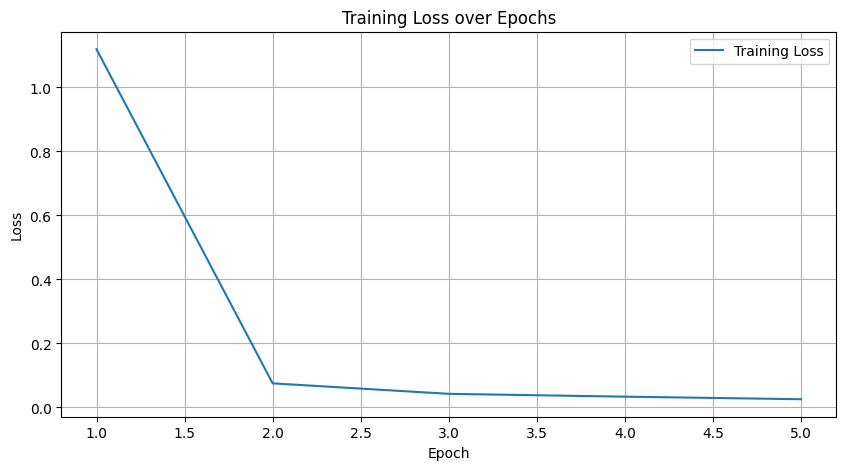

In [2]:
!pip install idx2numpy
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import idx2numpy
from sklearn.metrics import accuracy_score, f1_score
import time
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
def load_data():
    train_images_path = "/kaggle/input/mnist-dataset/train-images.idx3-ubyte"
    train_labels_path = "/kaggle/input/mnist-dataset/train-labels.idx1-ubyte"
    test_images_path = "/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte"
    test_labels_path = "/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte"
    
    train_images = idx2numpy.convert_from_file(train_images_path)
    train_labels = idx2numpy.convert_from_file(train_labels_path)
    test_images = idx2numpy.convert_from_file(test_images_path)
    test_labels = idx2numpy.convert_from_file(test_labels_path)
    
    return train_images, train_labels, test_images, test_labels

# Transformations for the dataset
def get_transform():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),
    ])

# Custom dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create data loaders
def get_data_loaders(train_images, train_labels, test_images, test_labels, transform):
    train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
    test_dataset = MNISTDataset(test_images, test_labels, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, test_loader

# Build the model
def build_model():
    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    vgg16.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)  # Adjust for grayscale input
    num_classes = 10
    vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)  # 10 classes for MNIST
    vgg16.features = torch.nn.Sequential(*list(vgg16.features.children())[:-1])  # Remove last pooling layer
    vgg16.to(device)
    
    return vgg16

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    training_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    return training_losses

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return accuracy, f1

# Main function to run everything
def main():
    # Load the data
    train_images, train_labels, test_images, test_labels = load_data()

    # Normalize the data
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Get transformations and data loaders
    transform = get_transform()
    train_loader, test_loader = get_data_loaders(train_images, train_labels, test_images, test_labels, transform)

    # Build model
    model = build_model()

    # Define loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train the model
    start_time = time.time()
    training_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    # Evaluate the model
    accuracy, f1 = evaluate_model(model, test_loader)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Epoch 1/5, Loss: 0.5870
Epoch 2/5, Loss: 0.0667
Epoch 3/5, Loss: 0.0460
Epoch 4/5, Loss: 0.0351
Epoch 5/5, Loss: 0.0287
Training Time: 264.15 seconds
Accuracy: 0.9931
F1 Score: 0.9931


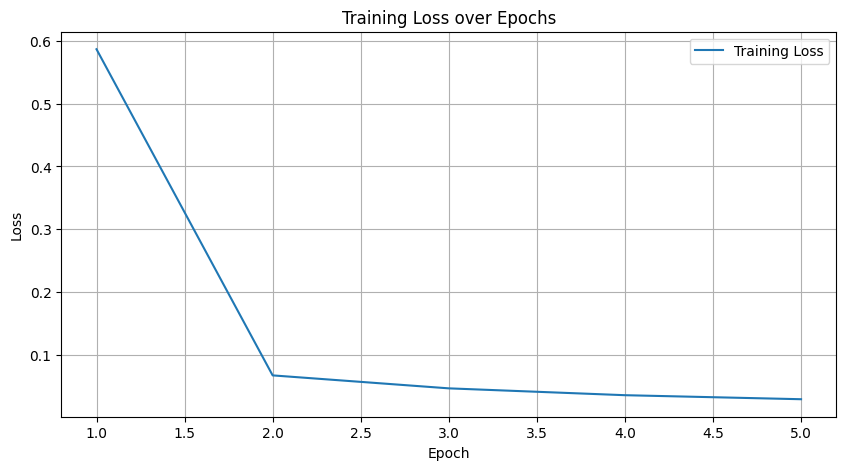

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import idx2numpy
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import time

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
def load_data():
    train_images_path = "/kaggle/input/mnist-dataset/train-images.idx3-ubyte"
    train_labels_path = "/kaggle/input/mnist-dataset/train-labels.idx1-ubyte"
    test_images_path = "/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte"
    test_labels_path = "/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte"
    
    train_images = idx2numpy.convert_from_file(train_images_path)
    train_labels = idx2numpy.convert_from_file(train_labels_path)
    test_images = idx2numpy.convert_from_file(test_images_path)
    test_labels = idx2numpy.convert_from_file(test_labels_path)
    
    return train_images, train_labels, test_images, test_labels

# Transformations for the dataset
def get_transform():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to 224x224 as AlexNet requires
        transforms.ToTensor(),
    ])

# Custom dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create data loaders
def get_data_loaders(train_images, train_labels, test_images, test_labels, transform):
    train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
    test_dataset = MNISTDataset(test_images, test_labels, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, test_loader

# Define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),  # Adjusted for 1 channel (grayscale)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer
        x = self.classifier(x)
        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    training_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    return training_losses

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return accuracy, f1

# Main function to run everything
def main():
    # Load the data
    train_images, train_labels, test_images, test_labels = load_data()

    # Normalize the data
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Get transformations and data loaders
    transform = get_transform()
    train_loader, test_loader = get_data_loaders(train_images, train_labels, test_images, test_labels, transform)

    # Build model
    model = AlexNet(num_classes=10).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train the model
    start_time = time.time()
    training_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
    training_time = time.time() - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    # Evaluate the model
    accuracy, f1 = evaluate_model(model, test_loader)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
